<a href="https://colab.research.google.com/github/SiraHaruethaipree/Resnet50-visiontransformer/blob/main/Alien_vs_Predator_resnet%2Btransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resnet50+transformer

notebook นี้จัดทำมาเพื่อการนำโมเดล Vision transformer ไปประยุกต์ใช้งานกับโมเดล Resnet50 ซึ่งในแต่ละโมเดลได้มีการอธิบายรายละเอียด ทฤษฎีการทำงาน ไว้ในบทความ ดังนี้


1.  สร้างโมเดล Vision Transformer + Resnet50 in PyTorch [past 1/3] : VIT Vision Transformer [Link medium](https://medium.com/@guisira/%E0%B8%AA%E0%B8%A3%E0%B9%89%E0%B8%B2%E0%B8%87%E0%B9%82%E0%B8%A1%E0%B9%80%E0%B8%94%E0%B8%A5-vision-transformer-resnet50-in-pytorch-past-1-3-vit-vision-transformer-b458460d580f)
2.  สร้างโมเดล Vision Transformer + Resnet50 in PyTorch [past 2/3] : RESNET50 [Link medium](https://medium.com/@guisira/%E0%B8%AA%E0%B8%A3%E0%B9%89%E0%B8%B2%E0%B8%87%E0%B9%82%E0%B8%A1%E0%B9%80%E0%B8%94%E0%B8%A5-vision-transformer-resnet50-in-pytorch-past-2-3-resnet50-b39c937f6e56)
3. สร้างโมเดล Vision Transformer + Resnet50 in PyTorch [past 3/3] : Vision Transformer + Resnet50 [Link medium](https://medium.com/@guisira/%E0%B8%AA%E0%B8%A3%E0%B9%89%E0%B8%B2%E0%B8%87%E0%B9%82%E0%B8%A1%E0%B9%80%E0%B8%94%E0%B8%A5-vision-transformer-resnet50-in-pytorch-past-3-3-vision-transformer-resnet50-423ad00a39ef)



# Import library and Dataset

การ import dataset ที่เราจะใช้จะได้มาจาก [Alien vs. Predator images](https://www.kaggle.com/datasets/pmigdal/alien-vs-predator-images) ของ kaggle ซึ่งเป็นรูปภาพสำหรับงาน clssification ระหว่าง Alien และ Predator โดยภายในจะมีจำนวนรูปภาพอยู่ที่จำนวน 500 รูป และแต่ละ class จะมีขนาดเท่ากัน 

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"guisira","key":"05ff07f8466e08bc8b1ec4b211fba205"}'}

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d pmigdal/alien-vs-predator-images

 64% 9.00M/14.1M [00:00<00:00, 93.1MB/s]
100% 14.1M/14.1M [00:00<00:00, 112MB/s] 


In [ ]:
! unzip /content/alien-vs-predator-images.zip

Archive:  /content/alien-vs-predator-images.zip
  inflating: alien_vs_predator_thumbnails/data/train/alien/0.jpg  
  inflating: alien_vs_predator_thumbnails/data/train/alien/1.jpg  
  inflating: alien_vs_predator_thumbnails/data/train/alien/10.jpg  
  inflating: alien_vs_predator_thumbnails/data/train/alien/100.jpg  
  inflating: alien_vs_predator_thumbnails/data/train/alien/101.jpg  
  inflating: alien_vs_predator_thumbnails/data/train/alien/102.jpg  
  inflating: alien_vs_predator_thumbnails/data/train/alien/103.jpg  
  inflating: alien_vs_predator_thumbnails/data/train/alien/104.jpg  
  inflating: alien_vs_predator_thumbnails/data/train/alien/105.jpg  
  inflating: alien_vs_predator_thumbnails/data/train/alien/106.jpg  
  inflating: alien_vs_predator_thumbnails/data/train/alien/107.jpg  
  inflating: alien_vs_predator_thumbnails/data/train/alien/108.jpg  
  inflating: alien_vs_predator_thumbnails/data/train/alien/109.jpg  
  inflating: alien_vs_predator_thumbnails/data/train/alien/1

In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 453 kB/s 


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import cv2

import numpy as np
from torch import nn
from torch import Tensor
from PIL import Image
from torchvision import transforms
import torchvision 
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.utils import shuffle
import torchvision.models as models
import gc
from tqdm import tqdm
import torch.optim as optim
import random
import pandas as pd
from sklearn.utils import shuffle
import time

# Prepare data

ขั้นตอนการเตรียมข้อมูลเนื่องจากข้อมูล image ที่เข้ามาอยู่ในรูปของ file directory เพราะฉะนั้นเราจะทำการปรับให้ตำแหน่งของข้อมูล ประเภทของข้อมูลอยู่ใน Data frame เพื่อง่ายต่อการตรวจสอบ

In [ ]:
train_path = "/content/data/train"
path_train = []
label_train = []
for root, dirs, files in os.walk(train_path):
  for name in files:
    filename = os.path.join(root, name)
    path_train.append(filename)
      #labels
for i in path_train:
    label = i.rsplit('/', 2)[-2]
    label_train.append(label)


In [ ]:
valid_path = "/content/data/validation"
path_valid = []
label_valid = []
for root, dirs, files in os.walk(valid_path):
  for name in files:
    filename = os.path.join(root, name)
    path_valid.append(filename)
      #labels
for i in path_valid:
    label = i.rsplit('/', 2)[-2]
    label_valid.append(label)

# Label data 

การ encode label data เราจะกำหนดให้ predator = 1 และ Alien = 0

In [ ]:
df_train_data = {'Images':path_train, 'labels':label_train} 
df_train_data = pd.DataFrame(df_train_data) 
df_train_data["encoded_labels"] = df_train_data["labels"].apply(lambda x : 0 if x == "alien" else 1)

In [ ]:
df_train_data.head()

,Images,labels,encoded_labels
0,/content/data/train/predator/162.jpg,predator,1
1,/content/data/train/predator/252.jpg,predator,1
2,/content/data/train/predator/242.jpg,predator,1
3,/content/data/train/predator/64.jpg,predator,1
4,/content/data/train/predator/212.jpg,predator,1


In [ ]:
df_valid_data = {'Images':path_valid, 'labels':label_valid} 
df_valid_data = pd.DataFrame(df_valid_data) 
df_valid_data["encoded_labels"] = df_valid_data["labels"].apply(lambda x : 0 if x == "alien" else 1)

In [ ]:
df_valid_data.head()

,Images,labels,encoded_labels
0,/content/data/validation/predator/64.jpg,predator,1
1,/content/data/validation/predator/78.jpg,predator,1
2,/content/data/validation/predator/26.jpg,predator,1
3,/content/data/validation/predator/40.jpg,predator,1
4,/content/data/validation/predator/83.jpg,predator,1


ใช้ shuffle เพื่อทำการสุ่มค่าจัดเรียงค่าแบบสุ่มใน dataframe แทนที่การทำใน dataloader 

In [ ]:
df_train_data = shuffle(df_train_data, random_state=0)
df_valid_data = shuffle(df_valid_data, random_state=0)

In [ ]:
df_train_data.head()

,Images,labels,encoded_labels
491,/content/data/train/alien/194.jpg,alien,0
144,/content/data/train/predator/194.jpg,predator,1
602,/content/data/train/alien/49.jpg,alien,0
435,/content/data/train/alien/307.jpg,alien,0
474,/content/data/train/alien/183.jpg,alien,0


In [ ]:
df_valid_data.head()

,Images,labels,encoded_labels
18,/content/data/validation/predator/73.jpg,predator,1
170,/content/data/validation/alien/59.jpg,alien,0
107,/content/data/validation/alien/24.jpg,alien,0
98,/content/data/validation/predator/34.jpg,predator,1
177,/content/data/validation/alien/96.jpg,alien,0


# Create dataset and dataloader 

กำหนดค่า configuration ที่จะใช้ภายใน notebook นี้ และทำการสร้าง image dataset เพื่อให้ใช้กับ Dataloader โดยที่จะมีการกำหนด train set และ validation set และมีขนาด Batch size เท่ากับ 32 

In [ ]:
CONFIG = {
    'EPOCHS': 50,
    'img_size': 256,
    'seed': 22,
    'train_batch_size': 32,
    'test_batch_size': 32,
    'num_classes': 2,
}

CONFIG

{'EPOCHS': 50,
 'img_size': 256,
 'seed': 22,
 'train_batch_size': 32,
 'test_batch_size': 32,
 'num_classes': 2}

In [ ]:
torch.manual_seed(101)
train_transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.ToTensor(),
                               transforms.Resize((CONFIG['img_size'],CONFIG['img_size'])),
                                transforms.RandomHorizontalFlip(),
                                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

valid_transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.ToTensor(),
                               transforms.Resize((CONFIG['img_size'],CONFIG['img_size'])),
                                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None):
      self.df = df
      self.file_names = df['Images'].values
      self.labels = df['encoded_labels'].values
      self.transform = transform

    def __len__(self):
          return len(self.labels)

    def __getitem__(self, idx):
          img_path = self.file_names[idx]
          labels = self.labels[idx]
          image = cv2.imread(img_path, cv2.IMREAD_COLOR)
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          if self.transform:
              image = self.transform(image)
          return image, labels

In [ ]:
tran_dataset = CustomImageDataset(df_train_data,  train_transform)
valid_dataset = CustomImageDataset(df_valid_data,  valid_transform)
train_dataloader = DataLoader(tran_dataset, batch_size=CONFIG['train_batch_size'], shuffle=False, num_workers=0)
valid_dataloader = DataLoader(valid_dataset,batch_size=CONFIG["test_batch_size"], shuffle=False, num_workers=0)


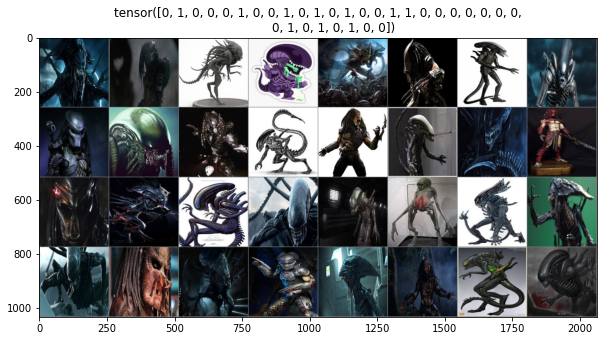

In [ ]:
def imshow(img, title = None):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
      plt.title(title)
    plt.show()


# get some random training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images), title= labels)

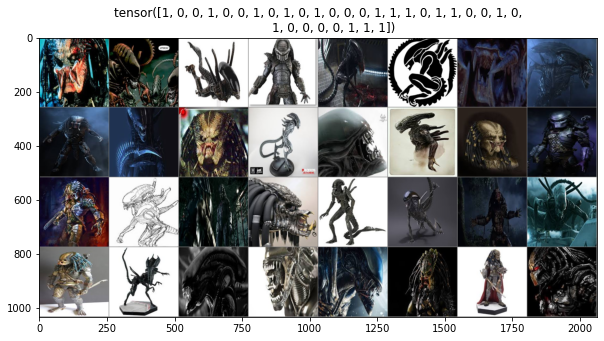

In [ ]:
def imshow(img, title = None):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
      plt.title(title)
    plt.show()


# get some random training images
dataiter = iter(valid_dataloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images), title= labels)

กำหนดการเรียกใช้ device ของ GPU

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Transformer

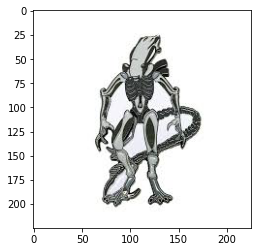

In [ ]:
img = Image.open('/content/data/train/alien/0.jpg')

fig = plt.figure()
plt.imshow(img)

In [ ]:
# resize to imagenet size 
transform_test = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
x = transform_test(img)
x = x.unsqueeze(0) # add batch dim
x.shape

torch.Size([1, 3, 256, 256])

In [ ]:
patch_size = 16 # 16 pixels
pathes = rearrange(images, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)

**Patch-Embedding** 

input image จะถูกแบ่งออกเป็นขนาด 16x16 flatten patches และมีการเพิ่ม cls token ที่ส่วนต้นของ patch และนำไปรวมกับ positional encoding โดยในทีนี้เราจะใช้ Conv2d แทนการใช้ linear layer ซึ่งสามารถทดแทนกันได้ โดยจะต้องกำหนด kernel_size และ stirde ให้มีค่าเท่ากับ patches size ที่เรากำหนดและทำการ flatten ผลลัพธ์ออกมาโดยใช้คำสั่ง Rearrange ของไลบรารี่ einops

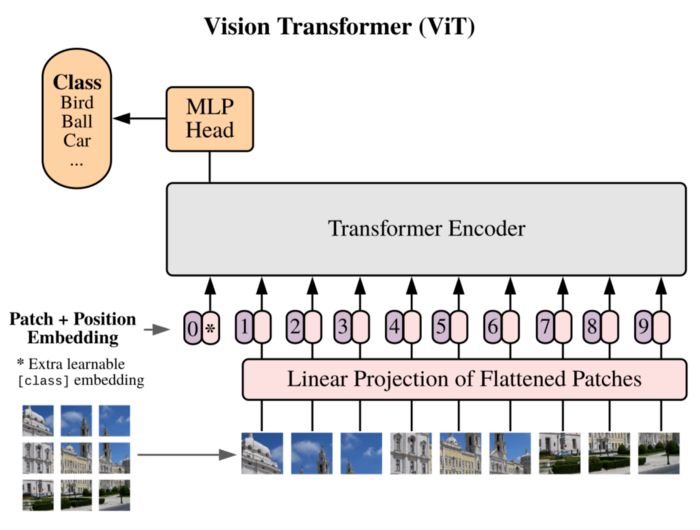

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = 256):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'), 
        ) #(32 (16*16) 768)
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))

        
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x) #(32, 256, 768) 
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b) #(32, 1, 768)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1) #([32, 257, 768])
        # add position embedding
        x += self.positions
        return  x

**Attention**

Attention จะประกอบไปด้วย 3 input คือ queries, keys, และ values โดยจะมีการกำหนดที่ชื่อว่า multi-head attention หมายความว่าการคำนวณจะถูกแยกออกเป็นขนาดตามจำนวน head

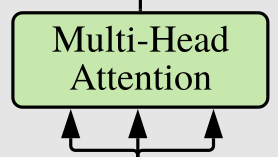

ซึ่ง queries, keys และ values จะเป็นค่าที่ได้มาจาก layer ก่อนหน้า และทำการแบ่งออกเป็น 3 linear layer โดยผลลัพธ์การ rearrange จะขึ้นอยู่กับจำนวน multiple head จึงทำให้ queries, key และ values จะมีขนาดเหมือนกัน โดยที่จะมีขนาดเท่ากับ [Batch, heads, Sequence_len, embedding_size]

การคำนวณจะอ้างอิงจาก The Illustrated Transformer จะทำการ dot product ระหว่าง query vector และ key vector โดยใช้ Torch.eisum โดยผลลัพธ์ที่ได้จะมีขนาด [Batch, Heads, Query_len, key_len] และหลังจากนั้นจะนำไปหารกับขนาดของ embedding ที่มีค่าเท่ากับ sqrt(d) เพื่อทำการ scaling และส่งไปยัง softmax function เมื่อได้ค่ามาแล้วจะนำไป dot product กับ value vector และส่งไปยัง block ถัดไป

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

**Residuals**

อีกส่วนหนึ่งที่มีอยู่ใน encoder block คือ residuals ซึ่งจะเป็นส่วนที่ดำเนินการถัดมาจากการทำ multi-head attention โดยก่อนหน้าที่เราจะนำ input ที่ได้จากหลังจากทำ positional encoding แล้วเราจะทำการเก็บค่านั้นไว้แล้วจะนำมาบวกเข้ากับส่วนผลลัพธ์ที่ได้จากการทำ multi-head attention โดยใน 1 encoder block จะมีการทำ Residuals Add อยู่สองครั้ง นั้นก็คือหลังจากทำ multi-head attention กับ MLP

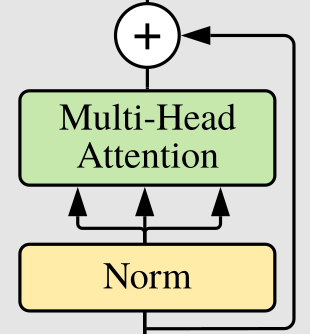

In [ ]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

**MLP**

Output ที่ได้จากการ attention และ Normalize จะถูกนำเข้าไปยัง fully connected layer ที่มีจำนวน 2 linear layer ด้านใน โดยจะมีการ upsample โดยการกำหนด expansion ใน layer แรก

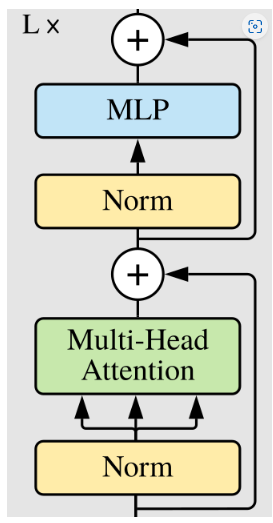

In [ ]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int = 768, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

เมื่อทำการสร้าง class ครบทุกองค์ประกอบของ Encoder block แล้ว จะนำทั้งหมดที่กล่าวมารวมกันอยู่ใน block เดียวกันที่เรียกว่า encoder block

In [ ]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

โดยใน transformer นั้นเราสามารถต่อ encoder block หลายๆ block ต่อกันได้ ในที่นี้เราจะใช้อยู่ที่ 12 block

In [ ]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

หลังจากนั้นจะเป็นส่วนหนึ่งที่สำคัญในการใช้ทำ classification โดยผลลัพธ์สุดท้ายที่ได้จาก layer สุดท้ายที่ของ MLP ที่อยู่ใน encoder block สุดท้ายไปทำการหา class probability เพื่อใช้ในการทำนายต่อไป

In [ ]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 2):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes))

ขั้นตอนสุดท้ายทำการรวมขั้นตอนทั้งหมดประกอบเข้าด้วยกันก่อนจะนำไป training ทั้ง PatchEmbedding, TransformerEncoder และ Classificationhead

In [ ]:
class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 256,
                depth: int = 12,
                n_classes: int = 2,
                **kwargs):
        super(ViT, self).__init__()
        self.PatchEmb = PatchEmbedding(in_channels, patch_size, emb_size, img_size)
        self.transencode = TransformerEncoder(depth, emb_size=emb_size, **kwargs)
        self.classifiyhead = ClassificationHead(emb_size, n_classes)

    def forward(self, x):
        x = self.PatchEmb(x)
        x = self.transencode(x)
        h = self.classifiyhead(x)
        return h

In [ ]:
vit = ViT()
vit.to(device)

ViT(
  (PatchEmb): PatchEmbedding(
    (projection): Sequential(
      (0): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (1): Rearrange('b e (h) (w) -> b (h w) e')
    )
  )
  (transencode): TransformerEncoder(
    (0): TransformerEncoderBlock(
      (0): ResidualAdd(
        (fn): Sequential(
          (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (1): MultiHeadAttention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (att_drop): Dropout(p=0, inplace=False)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (2): Dropout(p=0.0, inplace=False)
        )
      )
      (1): ResidualAdd(
        (fn): Sequential(
          (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (1): FeedForwardBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate=none)
            (2): Dropout(p=0.0, inplace=Fals

In [ ]:
torch.cuda.empty_cache()

ในการ train ข้อมูลจะกำหนดจำนวน epoch อยู่ที่ 50 epochs และใช้ adam optimizer ที่มี learning rate = 1e-5

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit.parameters(), lr=1e-5)

In [ ]:
training_loss_trans = []
training_Acc_trans = []
train_batch   = CONFIG['train_batch_size']

start_trans = time.time()
for epoch in range( CONFIG['EPOCHS']):  
     
      gc.collect()
      vit.train()
      train_epoch_loss = 0
      train_epoch_acc = 0

      bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
      for step, batch in bar:
          images, labels = batch
          images = images.to(device)
          labels= labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

        # forward + backward + optimize
          outputs = vit(images)
          _,preds    = torch.max ( torch.softmax(outputs, dim = 1), 1)
         
          running_corrects = torch.sum(preds == labels)

          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          train_epoch_loss += loss.item()
          train_epoch_acc += running_corrects.item()/train_batch
          
          bar.set_description(f'loss: {loss.item()} acc: {running_corrects.item()/train_batch} batch_id: {step}')
          bar.set_postfix(Epoch=epoch+1, Train_Loss=train_epoch_loss/len(train_dataloader),
                          Train_ACC=train_epoch_acc/len(train_dataloader),LR=optimizer.param_groups[0]['lr']) 
      
      training_loss_trans.append(train_epoch_loss/len(train_dataloader))
      training_Acc_trans.append(train_epoch_acc/len(train_dataloader))
      gc.collect()

print('Finished Training')
end_trans = time.time()
time_trans = end_trans - start_trans

loss: 0.9511719346046448 acc: 0.3125 batch_id: 21: 100%|██████████| 22/22 [00:39<00:00,  1.80s/it, Epoch=1, LR=1e-5, Train_ACC=0.557, Train_Loss=0.864]
loss: 0.7214856743812561 acc: 0.3125 batch_id: 21: 100%|██████████| 22/22 [00:35<00:00,  1.61s/it, Epoch=2, LR=1e-5, Train_ACC=0.543, Train_Loss=0.705]
loss: 0.758575439453125 acc: 0.25 batch_id: 21: 100%|██████████| 22/22 [00:34<00:00,  1.56s/it, Epoch=6, LR=1e-5, Train_ACC=0.561, Train_Loss=0.666]
loss: 0.7510502338409424 acc: 0.3125 batch_id: 21: 100%|██████████| 22/22 [00:34<00:00,  1.57s/it, Epoch=7, LR=1e-5, Train_ACC=0.572, Train_Loss=0.663]
loss: 0.7460293173789978 acc: 0.3125 batch_id: 21: 100%|██████████| 22/22 [00:34<00:00,  1.58s/it, Epoch=8, LR=1e-5, Train_ACC=0.587, Train_Loss=0.659]
loss: 0.7402705550193787 acc: 0.3125 batch_id: 21: 100%|██████████| 22/22 [00:34<00:00,  1.57s/it, Epoch=9, LR=1e-5, Train_ACC=0.591, Train_Loss=0.654]
loss: 0.7327163815498352 acc: 0.3125 batch_id: 21: 100%|██████████| 22/22 [00:34<00:00,  1.

Finished Training


# resnet 50

เริ่มต้นเราจะสร้างส่วน Convolution block ก่อน โดยส่วนนี้จะเป็นส่วนย่อยที่สุด ที่จะอยู่ในแต่ละ Residual block โดยจะประกอบไปด้วย convolutional layer และ Batchnormalize

In [ ]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
    super().__init__()
    self.c = nn.Conv2d(in_channels=in_channels, out_channels = out_channels, kernel_size = kernel_size, stride = stride, padding = padding)
    self.bn = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    return self.bn(self.c(x))

ในส่วนถัดมาจะสร้าง Residual block โดยที่ภายในจะมีการเรียกใช้ ConvBlock ที่เราได้ทำการสร้างก่อนหน้าโดยจะมีจำนวน 3 ConvBlock ในทุกๆ Risidual block ดังที่วงกลมไว้ในตารางด้านล่าง โดยจะมีการกำหนด output_chanel, kernel_size, stride, padding ตามตารางที่แสดงด้านล่าง

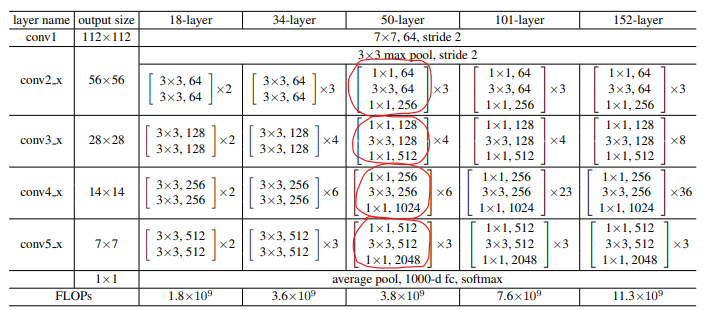

In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, first = False):
    super().__init__()
    res_channels = in_channels//4
    stride = 1

    self.projection = in_channels != out_channels
    if self.projection :
      self.p = ConvBlock(in_channels, out_channels, 1, 2, 0)
      stride = 2
      res_channels = in_channels // 2

    if first:
      self.p = ConvBlock(in_channels, out_channels, 1, 1, 0)
      stride = 1
      res_channels = in_channels

    self.c1 = ConvBlock(in_channels, res_channels, 1, 1, 0)
    self.c2 = ConvBlock(res_channels, res_channels, 3, stride, 1)
    self.c3 = ConvBlock(res_channels, out_channels, 1, 1, 0)
    self.relu = nn.ReLU()

  def forward(self, x):
    f = self.relu(self.c1(x))
    f = self.relu(self.c2(f))
    f = self.c3(f)

    if self.projection:
      x = self.p(x)

    h = self.relu(torch.add(f,x))
    return h



*   projection จะทำงานแบบ convolutional block ที่กล่าวไปข้างต้นในกรณีที่ input_size ไม่เท่ากับ output_size จึงต้องมีการปรับขนาด image
*   c1,c2,c3 จะเป็นจำนวน Convolution layer ที่กำหนดดังตารางด้านบน
* first คือ conv1 ที่กำหนดใน layer name ของตารางด้านบน
* h จะเป็นค่าที่ได้จาก torch.add คือการรวมกันของ input x ก่อนเข้า Residual block กับ output หลัง residual block


หลังจากที่สร้าง Residual Block ออกมาแล้วในส่วนสุดท้ายนำทั้งหมดที่ได้มาต่อรวมกันเป็นโมเดล Resnet

In [ ]:
class ResNet(nn.Module):
  def __init__(self, config_name : int, in_channels = 3, classes = 2):
    super(ResNet, self).__init__()

    configurations = {
        50 : [3,4,6,3],
        101 : [3,4,23,3],
        152 : [3,8,36,3]
    }

    no_blocks = configurations[config_name]

    out_features = [256, 512, 1024, 2048]
    self.blocks = nn.ModuleList([ResidualBlock(64, 256, True)])

    for i in range(len(out_features)):
      if i > 0 :
        self.blocks.append(ResidualBlock(out_features[i-1], out_features[i]))
      for _ in range(no_blocks[i]-1):
        self.blocks.append(ResidualBlock(out_features[i], out_features[i]))

    self.conv1 = ConvBlock(in_channels, 64, 7, 2, 3)
    self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc1 = nn.Linear(2048, 512)
    self.fc2 = nn.Linear(512, classes)
    self.relu = nn.ReLU()
    self.init_weight()

    #resnet50 + tranformers 
    self.conv2 = nn.Conv2d(in_channels = 2048,out_channels =  192,kernel_size =  3, stride = 1, padding = 1)#emb_size = 192*2*2

  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.maxpool(x)
    for block in self.blocks:
      x = block(x)

    #resnet50 + tranformers 
    p = self.conv2(x)
    
    x = self.avgpool(x)
    x = torch.flatten(x,1)
    x = self.fc1(x)
    x = self.fc2(x)
    return x, p 


In [ ]:
resnet50 = ResNet(50)
resnet50.to(device)

ResNet(
  (blocks): ModuleList(
    (0): ResidualBlock(
      (p): ConvBlock(
        (c): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (c1): ConvBlock(
        (c): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (c2): ConvBlock(
        (c): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (c3): ConvBlock(
        (c): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (c1): ConvBlock(
        (c): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
        (bn): BatchNorm2d(64, eps=1

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=1e-5)

ในการ train ข้อมูลจะกำหนดจำนวน epoch อยู่ที่ 50 epochs และใช้ adam optimizer ที่มี learning rate = 1e-5

In [ ]:
training_loss_res = []
training_Acc_res = []
train_batch   = CONFIG['train_batch_size']
start_res = time.time()

for epoch in range( CONFIG['EPOCHS']):  
     
      gc.collect()
      resnet50.train()
      train_epoch_loss = 0
      train_epoch_acc = 0

      bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
      for step, batch in bar:
          images, labels = batch
          images = images.to(device)
          labels= labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

        # forward + backward + optimize
          outputs, _ = resnet50(images)
          _,preds    = torch.max ( torch.softmax(outputs, dim = 1), 1)
         

          running_corrects = torch.sum(preds == labels)

          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          train_epoch_loss += loss.item()
          train_epoch_acc += running_corrects.item()/train_batch
          
          bar.set_description(f'loss: {loss.item()} acc: {running_corrects.item()/train_batch} batch_id: {step}')
          bar.set_postfix(Epoch=epoch+1, Train_Loss=train_epoch_loss/len(train_dataloader),Train_ACC=train_epoch_acc/len(train_dataloader),LR=optimizer.param_groups[0]['lr']) 

      
      training_loss_res.append(train_epoch_loss/len(train_dataloader))
      training_Acc_res.append(train_epoch_acc/len(train_dataloader))
      gc.collect()

print('Finished Training')
end_res = time.time()
res_time = end_res - start_res

loss: 0.6958543658256531 acc: 0.375 batch_id: 21: 100%|██████████| 22/22 [00:11<00:00,  1.89it/s, Epoch=1, LR=1e-5, Train_ACC=0.571, Train_Loss=0.683]
loss: 0.6453618407249451 acc: 0.4375 batch_id: 21: 100%|██████████| 22/22 [00:11<00:00,  1.95it/s, Epoch=2, LR=1e-5, Train_ACC=0.643, Train_Loss=0.621]
loss: 0.6293724179267883 acc: 0.5 batch_id: 21: 100%|██████████| 22/22 [00:11<00:00,  1.95it/s, Epoch=3, LR=1e-5, Train_ACC=0.67, Train_Loss=0.598]
loss: 0.5544040203094482 acc: 0.46875 batch_id: 21: 100%|██████████| 22/22 [00:11<00:00,  1.95it/s, Epoch=4, LR=1e-5, Train_ACC=0.732, Train_Loss=0.544]
loss: 0.3785123825073242 acc: 0.625 batch_id: 21: 100%|██████████| 22/22 [00:11<00:00,  1.93it/s, Epoch=5, LR=1e-5, Train_ACC=0.784, Train_Loss=0.469]
loss: 0.1815575212240219 acc: 0.65625 batch_id: 21: 100%|██████████| 22/22 [00:11<00:00,  1.94it/s, Epoch=6, LR=1e-5, Train_ACC=0.864, Train_Loss=0.354]
loss: 0.21154113113880157 acc: 0.625 batch_id: 21: 100%|██████████| 22/22 [00:11<00:00,  1.9

Finished Training


# new method resnet50 + tranformers

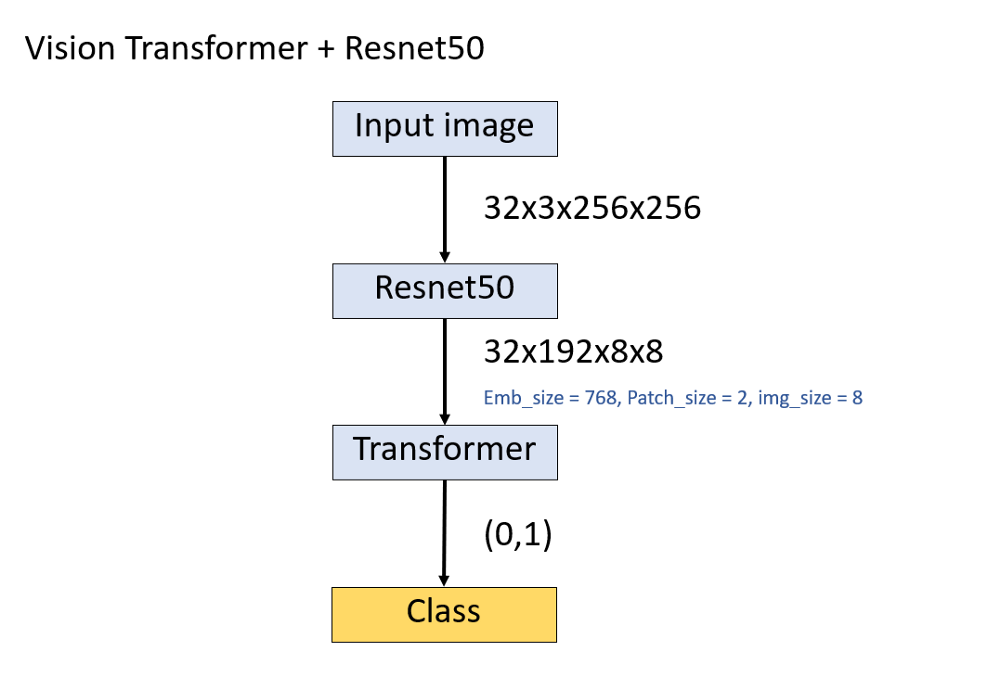

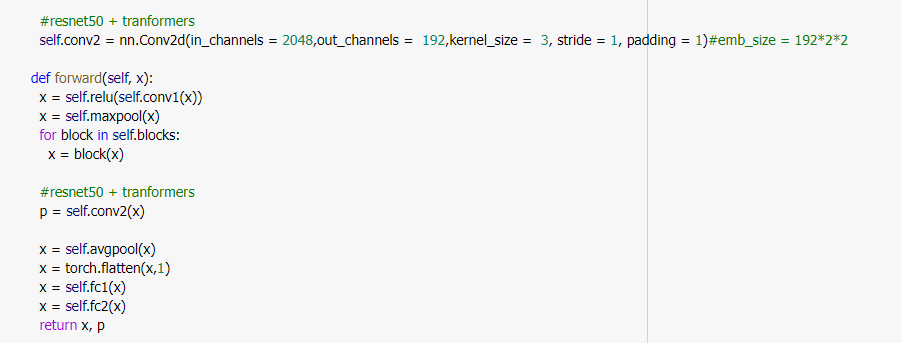

จะต้องทำการเพิ่มในส่วนของ Conv2 โดยต่อหลังจากการทำ Residual block สุดท้ายของโมเดล Resnet50 ที่มีขนาด channel เท่ากับ 2048 แปลงออกให้เป็นขนาด channel เท่ากับ 192 และเก็บค่าไว้ที่ p เพื่อนำออกมาใช้กับโมเดล Vision Transformer ต่อไป

In [ ]:
class Resnet_Transformers(nn.Module):
  def __init__(self, classes = 2, dp_rate = 0.2):
    super().__init__()
    self.tranformers = ViT(in_channels = 192, emb_size = 768, patch_size = 2, img_size = 8)
    self.resnet50 = ResNet(50)

  def forward(self, input):
    _ , res = self.resnet50(input)
    x  = self.tranformers(res)

    return x 

Resnet_Tranformers คืออีกส่วนหนึ่งที่เพิ่มขึ้นมาเพื่อจะทำการต่อโมเดลระหว่าง Resnet กับ Transformer เข้าด้วยกัน โดย input ที่จะเข้าไปยังโมเดล transformer นั้นเราได้กำหนดให้มี channel เท่ากับ 192 และมีขนาดรูปภาพ image size ขนาด 8x8 เพราะฉะนั้นเราจะต้องกำหนดขนาด patch size ให้มีขนาดเล็กกว่านั้น ในที่นี้จะกำหนดให้อยู่ที่ 2x2 ซึ่งจะเท่ากับว่า embedding size จะมีค่าเท่ากับ emb_size = in_channel x patch_size² = 192 x 2² = 768

In [ ]:
res_trans = Resnet_Transformers()
res_trans.to(device)

Resnet_Transformers(
  (tranformers): ViT(
    (PatchEmb): PatchEmbedding(
      (projection): Sequential(
        (0): Conv2d(192, 768, kernel_size=(2, 2), stride=(2, 2))
        (1): Rearrange('b e (h) (w) -> b (h w) e')
      )
    )
    (transencode): TransformerEncoder(
      (0): TransformerEncoderBlock(
        (0): ResidualAdd(
          (fn): Sequential(
            (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (1): MultiHeadAttention(
              (qkv): Linear(in_features=768, out_features=2304, bias=True)
              (att_drop): Dropout(p=0, inplace=False)
              (projection): Linear(in_features=768, out_features=768, bias=True)
            )
            (2): Dropout(p=0.0, inplace=False)
          )
        )
        (1): ResidualAdd(
          (fn): Sequential(
            (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (1): FeedForwardBlock(
              (0): Linear(in_features=768, out_features=3072, bias=True)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(res_trans.parameters(), lr=1e-5)

ในการ train ข้อมูลจะกำหนดจำนวน epoch อยู่ที่ 50 epochs และใช้ adam optimizer ที่มี learning rate = 1e-5

In [ ]:
training_loss_res_trans = []
training_Acc_res_trans = []

train_batch   = CONFIG['train_batch_size']
start_rt = time.time()

for epoch in range( CONFIG['EPOCHS']):  
     
      gc.collect()
      res_trans.train()
      train_epoch_loss = 0
      train_epoch_acc = 0

      bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
      for step, batch in bar:
          images, labels = batch
          images = images.to(device)
          labels= labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

        # forward + backward + optimize
          outputs = res_trans(images)
          _,preds    = torch.max(torch.softmax(outputs, dim = 1), 1)
         

          running_corrects = torch.sum(preds == labels)

          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          train_epoch_loss += loss.item()
          train_epoch_acc += running_corrects.item()/train_batch
          
          bar.set_description(f'loss: {loss.item()} acc: {running_corrects.item()/train_batch} batch_id: {step}')
          bar.set_postfix(Epoch=epoch+1, Train_Loss=train_epoch_loss/len(train_dataloader),Train_ACC=train_epoch_acc/len(train_dataloader),LR=optimizer.param_groups[0]['lr']) 

      training_loss_res_trans.append(train_epoch_loss/len(train_dataloader))
      training_Acc_res_trans.append(train_epoch_acc/len(train_dataloader))
      gc.collect()

print('Finished Training')
end_rt = time.time()
time_rt = end_rt - start_rt

loss: 0.9703112244606018 acc: 0.28125 batch_id: 21: 100%|██████████| 22/22 [00:14<00:00,  1.54it/s, Epoch=1, LR=1e-5, Train_ACC=0.509, Train_Loss=0.929]
loss: 0.690769374370575 acc: 0.3125 batch_id: 21: 100%|██████████| 22/22 [00:14<00:00,  1.52it/s, Epoch=2, LR=1e-5, Train_ACC=0.572, Train_Loss=0.687]
loss: 0.6598479747772217 acc: 0.34375 batch_id: 21: 100%|██████████| 22/22 [00:14<00:00,  1.52it/s, Epoch=3, LR=1e-5, Train_ACC=0.628, Train_Loss=0.644]
loss: 0.6739041805267334 acc: 0.34375 batch_id: 21: 100%|██████████| 22/22 [00:14<00:00,  1.51it/s, Epoch=4, LR=1e-5, Train_ACC=0.676, Train_Loss=0.604]
loss: 0.6617342829704285 acc: 0.34375 batch_id: 21: 100%|██████████| 22/22 [00:14<00:00,  1.56it/s, Epoch=5, LR=1e-5, Train_ACC=0.723, Train_Loss=0.557]
loss: 0.2014535814523697 acc: 0.6875 batch_id: 21: 100%|██████████| 22/22 [00:14<00:00,  1.55it/s, Epoch=6, LR=1e-5, Train_ACC=0.79, Train_Loss=0.427]
loss: 0.25238358974456787 acc: 0.625 batch_id: 21: 100%|██████████| 22/22 [00:14<00:00

Finished Training


# Evaluation

หลังจากที่เราได้ผลลัพธ์ของทั้งสามโมเดลแล้วทั้งโมเดล Vision transformer, Resnet50 และ Resnet50+Vision-transformer จะนำผลลัพธ์ที่ได้มาพลอต กราฟเปรียบเทียบแต่ละโมเดล

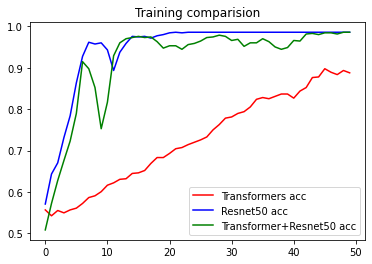

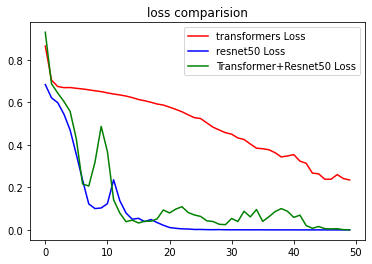

<Figure size 432x288 with 0 Axes>

In [ ]:
epochs = range(CONFIG['EPOCHS'])

plt.plot(epochs, training_Acc_trans, 'r', label='Transformers acc')
plt.plot(epochs, training_Acc_res, 'b', label='Resnet50 acc')
plt.plot(epochs, training_Acc_res_trans, 'g', label='Transformer+Resnet50 acc')
plt.title('Training comparision')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, training_loss_trans, 'r', label='transformers Loss')
plt.plot(epochs, training_loss_res, 'b', label='resnet50 Loss')
plt.plot(epochs, training_loss_res_trans, 'g', label='Transformer+Resnet50 Loss')
plt.title('loss comparision')
plt.legend(loc=0)
plt.figure()

plt.show()

จากกราฟด้านบนจะเห็นได้ว่าเมื่อทำการเปรียบเทียบทั้งสามโมเดล โดยกำหนดจำนวน epoch ที่ 50 นั้น จะเห็นได้ว่าโมเดล Resnet50 นั้นเรียนรู้ได้ดีกว่าโมเดลอื่นๆ ถัดลงมาเป็นโมเดล Resnet50+Vision-Transformer และลำดับสุดท้ายเป็นในส่วนของโมเดล Vision-Transformer ที่มีการเรียนรู้ช้าที่สุด

In [ ]:
PATH = './res_trans.pth'
torch.save(res_trans.state_dict(), PATH)

In [ ]:
# res_trans = Resnet_Transformers()
# res_trans.load_state_dict(torch.load(PATH))
# res_trans.to(device)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
classes = ('predator','alien')

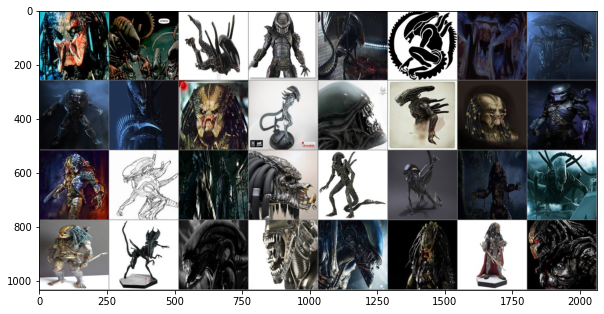

GroundTruth:  1 0 0 1 0 0 1 0 1 0 1 0 0 0 1 1 1 0 1 1 0 0 1 0 1 0 0 0 0 1 1 1


In [ ]:
dataiter = iter(valid_dataloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{labels[j]}' for j in range(32)))

In [ ]:
outputs = res_trans(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', predicted)

Predicted:  tensor([1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 1, 1, 1, 1, 1], device='cuda:0')


In [ ]:
correct = 0
correct += (predicted == labels.to(device)).sum().item()

In [ ]:
correct #จำนวนที่ถูกใน batch

16

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in valid_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = vit(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

valid_acc_vit = correct / total
print(f'Accuracy of the network on the  valid images: {100 * correct // total} %')

Accuracy of the network on the  valid images: 73 %


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in valid_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs, _ = resnet50(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

valid_acc_res = correct / total
print(f'Accuracy of the network on the  valid images: {100 * correct // total} %')

Accuracy of the network on the  valid images: 72 %


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in valid_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = res_trans(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

valid_acc_res_trans = correct / total
print(f'Accuracy of the network on the  valid images: {100 * correct // total} %')

Accuracy of the network on the  valid images: 65 %


In [ ]:
model_list = ["Vision Transformer","Resnet50","Resnet50+Vision Transformer"]
train_acc_list = [round(training_Acc_trans[-1],2), round(training_Acc_res[-1],2), round(training_Acc_res_trans[-1],2)]
train_loss_list = [round(training_loss_trans[-1],4), round(training_loss_res[-1],4), round(training_loss_res_trans[-1],4)]
valid_acc_list = [valid_acc_vit,valid_acc_res,valid_acc_res_trans]
time_compute = [time_trans, res_time, time_rt]
df_eval = {'model':model_list, 'train_accuracy':train_acc_list, "train_loss": train_loss_list, "valid_accuracy" : valid_acc_list, "time_computing(sec)" : time_compute} 
df_eval = pd.DataFrame(df_eval)

In [ ]:
df_eval

,model,train_accuracy,train_loss,valid_accuracy,time_computing(sec)
0,Vision Transformer,0.89,0.2350,0.735,1739.906080
1,Resnet50,0.99,0.0003,0.720,572.516882
2,Resnet50+Vision Transformer,0.99,0.0007,0.650,718.265267


และจากตารางจะแสดงให้เห็นว่าในเชิงตัวเลข accuracy, loss, เวลาในการคำนวณ โดยรวมแล้ว Resnet50 ถือว่าทำได้ดีกว่าตัวอื่นๆ ทั้ง train_accuracy, loss_accuracy และ เวลาในการคำนวณที่ลดลงกว่าโมเดล Vision transformer ธรรมดาถึงเกือบ 3 เท่า และในส่วนของ validation_accuracy อาจจะต่ำกว่า vision transformer ที่ได้ออกมาเนื่องจากโมเดลอาจจะมีปัญหา Overfit ซึ่งสามารถทำการแก้ไขโดยเพิ่ม dropout ในแต่ละ layer ได้

In [ ]:
validation_img_paths = ["/content/data/validation/alien/4.jpg","/content/data/validation/alien/13.jpg",
                        "/content/data/validation/predator/10.jpg","/content/data/validation/predator/22.jpg"]

In [ ]:
img_list = [Image.open(img_path) for img_path in validation_img_paths]

In [ ]:
test_transform =  transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor()])

In [ ]:
validation_batch = torch.stack([test_transform(img).to(device) for img in img_list])

In [ ]:
pred_logits_tensor = res_trans(validation_batch)
pred_logits_tensor

tensor([[ 5.7731, -5.7356],
        [ 1.7998, -1.3521],
        [-3.2164,  3.4213],
        [-4.3565,  3.6846]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
pred_probs

array([[9.99989986e-01, 1.00428815e-05],
       [9.58984673e-01, 4.10153009e-02],
       [1.30822568e-03, 9.98691738e-01],
       [3.21858475e-04, 9.99678135e-01]], dtype=float32)

หลังจากที่ train model แล้วเราจะลองนำโมเดลที่เราได้ทำการดัดแปลงมาทำการทดสอบโดยการสุ่มภาพดูว่าผลลัพธ์ของโมเดลที่สุ่ม จะถูกต้องหรือไม่

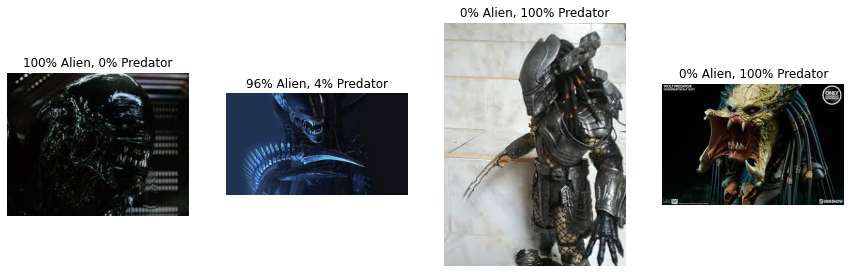

In [ ]:
fig, axs = plt.subplots(1, len(img_list), figsize=(15, 10))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Alien, {:.0f}% Predator".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)

# Conclusion

จากขั้นตอน Evaluation ที่แสดงผลลัพธ์ประสิทธิภาพของแต่ละโมเดล เราสามารถสรุปได้ว่าโมเดล Resnet50 ก็เพียงพอกับการใช้งาน Classification ข้อมูล Alien vs. Predator images แล้วถ้าอย่างนั้นแสดงว่าโมเดล Vision Transformer ไม่ดีหรอ? ซึ่งในเปเปอร์ก็ได้ระบุไว้ว่า

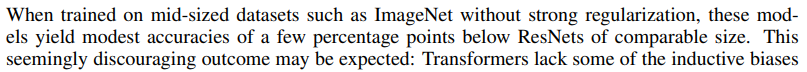

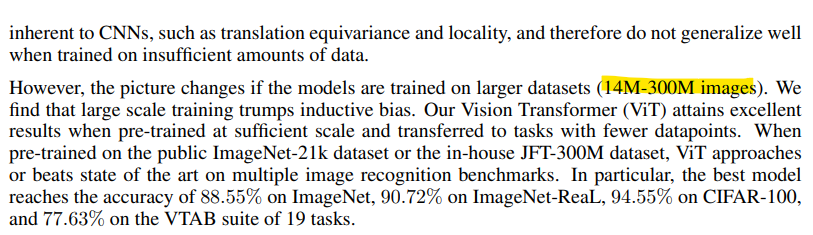

โมเดล Transformer นั้นประสิทธิภาพจะไม่ดีเท่าโมเดล Resnet เมื่อมีการนำโมเดลนี้ไปใช้กับชุดข้อมูลที่มีขนาดจำนวนข้อมูลน้อย หรือปานกลาง ในทีนี้เราใช้ชุดข้อมูลที่นำมาทดสอบมีจำนวนทั้งหมดเพียง 500 รูปเท่านั้น ในขณะเดียวกันเขายังพบว่าโมเดลจะทำงานได้ดีก็ต่อเมื่อมีจำนวนชุดข้อมูล 14M-300M รูปจึงจะทำให้มีประสิทธิภาพที่ยอดเยี่ยมเพราะฉะนั้นโมเดลนี้ควรจะนำไป pre-train กับข้อมูลที่มีขนาดใหญ่ก่อนแล้วค่อยมาทำการ fine-tune เพื่อปรับให้ตรงกับงานเฉพาะด้านที่เราจะนำไปใช้งานทีหลัง

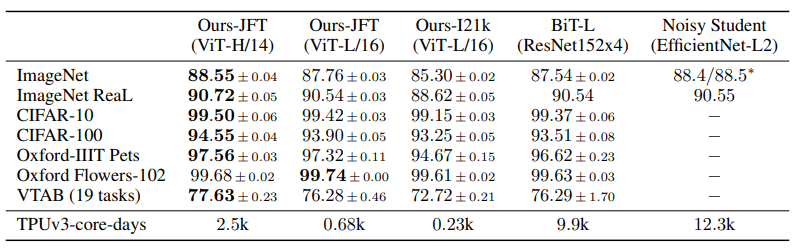

นอกจากนั้นในเปเปอร์ได้มีการทำการเปรียบเทียบโมเดล VIT หรือ Vision-Transformer กับโมเดลต่างๆ และชุดข้อมูลต่างจะเห็นได้ว่าโมเดล Vision-Transformer สามารถทำได้ดีกว่าโมเดลอื่นๆ ทั้งนี้การเลือกใช้โมเดล ก็ขึ้นอยู่กับความเหมาะสมของข้อมูล ชนิดของข้อมูล จำนวนของข้อมูล

# Reference

- Resnet + VIT 

https://medium.com/@james.sc.yan/using-pre-trained-vision-transformer-model-and-resnet-model-as-features-extractors-for-image-2292096e99a

https://www.youtube.com/watch?v=ffzmY7jW3n0

- Vision Transformers

https://towardsdatascience.com/implementing-visualttransformer-in-pytorch-184f9f16f632

https://openreview.net/pdf?id=YicbFdNTTy

https://github.com/nikhilroxtomar/Vision-Transformer-with-ResNet50-in-TensorFlow/blob/main/resnet50-vit.py

https://www.youtube.com/watch?v=TrdevFK_am4&t=1000s

- resnet

https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

https://blog.paperspace.com/writing-resnet-from-scratch-in-pytorch/

- Dataset

https://www.kaggle.com/datasets/pmigdal/alien-vs-predator-images

# Sira Haruethaipree 64607065